# RNN, LSTM, And GRU For Trading

# Importing Libraries

In [153]:
import numpy as np
import pandas as pd
import math
import datetime as dt
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
#Files
from util import fetchOnlineData, slice_df

# Initial variables

In [154]:
symbol = "AABA"

# We'll look back 365 days
start_d = dt.date.today() - dt.timedelta(365)

# Importing dataset

In [155]:
yesterday = dt.date.today() - dt.timedelta(1)
dataset = fetchOnlineData(start_d, symbol, yesterday, del_cols=False)

[*********************100%***********************]  1 of 1 downloaded


In [254]:
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-18,65.059998,65.449997,63.889999,64.639999,64.639999,10232800
2019-01-22,64.160004,64.160004,62.279999,63.009998,63.009998,9251300
2019-01-23,63.619999,64.150002,62.560001,62.869999,62.869999,4054700
2019-01-24,62.639999,64.199997,62.639999,64.000000,64.000000,6513200
2019-01-25,64.870003,65.870003,64.720001,65.220001,65.220001,7155800


In [157]:
df_stock = dataset.copy()
df_stock = df_stock.dropna()
df_stock = df_stock[['Open', 'High', 'Low', 'Close']]

# Data scaling

In [158]:
# data scaling (normalizing)
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# Splitting dataset

In [256]:
# Splitting the dataset into Train, Valid & test data 
valid_set_size_percentage = 10 
test_set_size_percentage = 10 
seq_len = 20 # taken sequence length as 20
def load_data(stock, seq_len):
    data_raw = stock.values
    data = [] 
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (184, 19, 4)
y_train.shape =  (184, 4)
x_valid.shape =  (23, 19, 4)
y_valid.shape =  (23, 4)
x_test.shape =  (23, 19, 4)
y_test.shape =  (23, 4)


# Building the model

In [160]:
# parameters & Placeholders 
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

## Function to get the next batch

In [161]:

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size 
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size     
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

## Layers

In [162]:
#RNN 
#layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#         for layer in range(n_layers)]
# LSTM  
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#         for layer in range(n_layers)]

#LSTM with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

#GRU 
layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
        for layer in range(n_layers)] 


In [163]:
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence

## Cost function

In [164]:
# Cost function
loss = tf.reduce_mean(tf.square(outputs - y))

## Optimizer

In [165]:
#optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

## Fitting the model

In [166]:
# Fitting the model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    print("Training model...")
    print("MSE (on training data):")
    training_mse = []
    validation_mse = []
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(iteration*batch_size/train_set_size, mse_train, mse_valid))
            # Add the loss metrics from this period to our list.
            training_mse.append(mse_train)
            validation_mse.append(mse_valid)
    print("Model training finished.")
    # Predictions
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})            

Training model...
MSE (on training data):
0.00 epochs: MSE train/valid = 0.278474/0.060890
4.89 epochs: MSE train/valid = 0.014121/0.008069
9.78 epochs: MSE train/valid = 0.010782/0.007768
14.67 epochs: MSE train/valid = 0.009296/0.007377
19.57 epochs: MSE train/valid = 0.007855/0.007263
24.46 epochs: MSE train/valid = 0.006286/0.006442
29.35 epochs: MSE train/valid = 0.005673/0.005729
34.24 epochs: MSE train/valid = 0.004859/0.005771
39.13 epochs: MSE train/valid = 0.003773/0.005064
44.02 epochs: MSE train/valid = 0.003244/0.004438
48.91 epochs: MSE train/valid = 0.003334/0.004446
53.80 epochs: MSE train/valid = 0.002837/0.004079
58.70 epochs: MSE train/valid = 0.002546/0.003906
63.59 epochs: MSE train/valid = 0.002394/0.003691
68.48 epochs: MSE train/valid = 0.002330/0.003549
73.37 epochs: MSE train/valid = 0.002235/0.003375
78.26 epochs: MSE train/valid = 0.002571/0.003415
83.15 epochs: MSE train/valid = 0.002477/0.003414
88.04 epochs: MSE train/valid = 0.002313/0.003351
92.93 epoch

Final RMSE (on training data):   0.02
Final RMSE (on validation data): 0.01


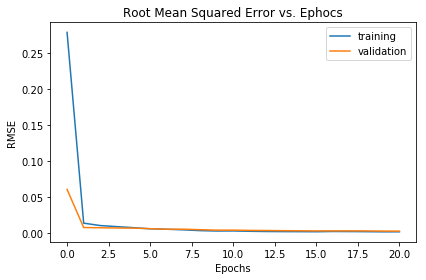

In [167]:
# Output a graph of loss metrics over periods.
plt.ylabel("RMSE")
plt.xlabel("Epochs")
plt.title("Root Mean Squared Error vs. Ephocs")
plt.tight_layout()
plt.plot(training_mse, label="training")
plt.plot(validation_mse, label="validation")
plt.legend()

t = np.array(training_mse)
v = np.array(validation_mse)
print("Final RMSE (on training data):   %0.2f" % t.mean())
print("Final RMSE (on validation data): %0.2f" % v.mean())


In [ ]:
# evaluate the model
scores = model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# Predictions

In [168]:
# Shaping prediction output
y_test_pred.shape

(23, 4)

## Standarized data and predictions

In [370]:

real_prediction = min_max_scaler.inverse_transform(y_test_pred)
real_price = min_max_scaler.inverse_transform(y_test)
real_price = real_price[:,3]

# Create a dataframe with prices and predictions for plotting
df_prices = df_stock.tail(real_price.size)
del df_prices['Open']
del df_prices['High']
del df_prices['Low']

# Create final dataframe
index = df_prices.index
comp = pd.DataFrame({'Real price':real_price,'Prediction':real_prediction[:,3]}, index=index)


# Plotting the graph

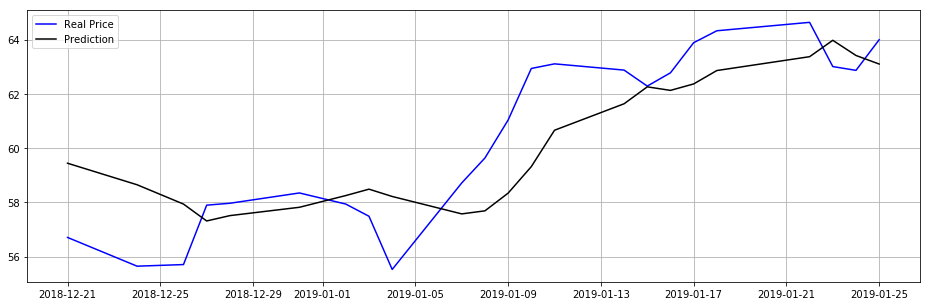

In [373]:
# ploting the graph
#comp = pd.DataFrame({'Real price':real_price[:,3],'Prediction':real_prediction[:,3]})
plt.figure(figsize=(16,5))
plt.plot(comp['Real price'], color='blue', label='Real Price')
plt.plot(comp['Prediction'], color='black', label='Prediction')
plt.legend()
plt.grid()
plt.show()

## Results

In [380]:
mse = metrics.mean_squared_error(y_test, y_test_pred)
print('Mean Squared Error:', mse)
prediction = real_prediction[:,3]
print(real_price, prediction)

accuracy = metrics.accuracy_score(real_price, prediction)
print('Accuracy:', accuracy)

Mean Squared Error: 0.0032708254452086345
[56.709999 55.650002 55.709999 57.900002 57.970001 58.349998 57.939999
 57.490002 55.529999 58.720001 59.639999 61.040001 62.939999 63.110001
 62.880001 62.290001 62.779999 63.889999 64.330002 64.639999 63.009998
 62.869999 64.      ] [59.446064 58.652203 57.94011  57.317657 57.51431  57.821884 58.254414
 58.490067 58.220657 57.578224 57.69082  58.343937 59.321606 60.66212
 61.638287 62.262394 62.131786 62.36936  62.863583 63.374218 63.978188
 63.419163 63.102936]


ValueError: continuous is not supported

# Saving

In [375]:
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver.save(sess, './gru_model')

'./gru_model'